In [1]:
#Imports necessarios para o funcionamento do modelo
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms


In [2]:
#Utilizar GPU se tiver disponivel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Mostrar se é CPU ou CUDA
device

device(type='cuda')

In [3]:
BATCH_SIZE = 32
NUM_WORKERS = 4

# Caminho para o dataset
dataset_path = 'images/Images'

# Transformações de data augmentation para treino
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256),            # Corta e redimensiona aleatoriamente para 256x256
    transforms.RandomHorizontalFlip(p=0.5),      # Flip horizontal com prob. 50%
    transforms.RandomRotation(degrees=15),       # Rotação aleatória até ±15°
    transforms.ColorJitter(                     # Variações de brilho, contraste e saturação
        brightness=0.2,
        contrast=0.2, 
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),                        # Converte para tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5],     # Normalização
                         std=[0.5, 0.5, 0.5])
])

# Transformações fixas para teste/validação
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Carrega o dataset sem transform, apenas para obter índices
base_dataset = ImageFolder(root=dataset_path, transform=None)

# Divide índices em treino (80%) e teste (20%)
dataset_size = len(base_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
torch.manual_seed(42)
train_indices, test_indices = random_split(
    list(range(dataset_size)),
    [train_size, test_size]
)

# Cria dois ImageFolder, um com train_transform e outro com test_transform
train_dataset_full = ImageFolder(root=dataset_path, transform=train_transform)
test_dataset_full  = ImageFolder(root=dataset_path, transform=test_transform)

# Subset para aplicar apenas os índices respectivos
train_dataset = Subset(train_dataset_full, train_indices)
test_dataset  = Subset(test_dataset_full, test_indices)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# Informações sobre tamanho do dataset | dados de treino | dados de teste
num_classes = len(base_dataset.classes)
print(f"Total de imagens: {dataset_size}")
print(f"Imagens para treino: {len(train_dataset)}")
print(f"Imagens para teste: {len(test_dataset)}")
print(f"Tamanho do batch dos data loaders: {BATCH_SIZE}")

Total de imagens: 20580
Imagens para treino: 16464
Imagens para teste: 4116
Tamanho do batch dos data loaders: 32


In [4]:
#Verificar numero de classes no dataset
num_classes = len(base_dataset.classes)
num_classes

120

In [5]:
#Modelo CNN
class ScratchCNN(nn.Module):
    def __init__(self, num_classes: int):
        super(ScratchCNN, self).__init__()
        self.features = nn.Sequential(
            # Bloco 1: 3 -> 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 224 -> 112

            # Bloco 2: 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 112 -> 56

            # Bloco 3: 128 -> 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 56 -> 28

            # Bloco 4: 256 -> 512
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28 -> 14

            # Bloco 5: 512 -> 512
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14 -> 7

            # Adaptive pooling: 7x7 -> 1x1
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),             # 512 x 1 x 1 -> 512
            nn.Dropout(p=0.5),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x

In [6]:
# Otimizador e scheduler
model = ScratchCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,            # comece em 1e-2 ou 1e-3
    momentum=0.9,       # acelera direção do gradiente
    weight_decay=1e-4   # L2 regularização
)

#Adicionar scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)  # Reduz a taxa de aprendizado a cada 10 epocas


In [7]:
# Caminho para salvar os checkpoints do treinamento do modelo
CHECKPOINT_PATH = "checkpoint.pth"
BEST_MODEL_DIR = "Modelos"
os.makedirs(BEST_MODEL_DIR, exist_ok=True) # Cria o diretório se não existir

# Variáveis para o loop de treinamento
num_epochs = 500
best_val_loss = float('inf')
start_epoch = 0 # Começa da época 0 por padrão

# Listas para armazenar perdas e acurácia
train_losses = []
val_losses = []
accuracies = []

# Carregar checkpoint se existir
if os.path.exists(CHECKPOINT_PATH):
    print(f"Carregando checkpoint de '{CHECKPOINT_PATH}'")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device) # map_location para carregar em CPU se treinado em GPU
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1 # Começa da próxima época da que o checkpoint foi salvo
    best_val_loss = checkpoint['best_val_loss']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    accuracies = checkpoint['accuracies']
    print(f"Checkpoint carregado. Reiniciando da época {start_epoch}.")
else:
    print("Nenhum checkpoint encontrado. Iniciando treinamento do zero.")

scaler = GradScaler(enabled=(device.type == 'cuda')) # Para precisão mista, habilitar apenas para CUDA

print(f"Iniciando treinamento da época {start_epoch + 1} até {num_epochs}")

#Loop de treinamento
for epoch in range(start_epoch, num_epochs):
    #Treinamento do modelo
    model.train()
    running_loss = 0.0
    start_time = time.time()

    train_progress_bar = tqdm(train_loader, desc=f"Época {epoch+1}/{num_epochs} - Treino", leave=False)
    for images, labels in train_progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast(enabled=(device.type == 'cuda')): # Mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)

        if device.type == 'cuda':
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else: # Para CPU
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        train_progress_bar.set_postfix(loss=loss.item())



    # Validacao do modelo
    model.eval()
    val_loss_epoch = 0.0
    correct = 0
    total = 0
    val_progress_bar = tqdm(test_loader, desc=f"Época {epoch+1}/{num_epochs} - Validação", leave=False)
    with torch.no_grad():
        with autocast(enabled=(device.type == 'cuda')): # Precisao mista
            for images, labels in val_progress_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_epoch += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_progress_bar.set_postfix(loss=loss.item())



    # Calcular metricas de desempenho
    epoch_train_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss_epoch / len(test_loader)
    accuracy = 100 * correct / total
    end_time = time.time()

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    accuracies.append(accuracy)

    print(f"Época [{epoch+1}/{num_epochs}], "
          f"Perda Treino: {epoch_train_loss:.4f}, "
          f"Perda Val: {epoch_val_loss:.4f}, "
          f"Acurácia Val: {accuracy:.2f}%, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}, " # Mostra a taxa de aprendizado atual
          f"Tempo: {end_time - start_time:.2f}s")

    scheduler.step(epoch_val_loss)

    # Salvar o melhor modelo se a val_loss for menor que a melhor anterior
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_path = os.path.join(BEST_MODEL_DIR, f'epoca_{epoch+1}_best_model_acc_{accuracy:.2f}_loss_{epoch_val_loss:.4f}.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"Melhor modelo salvo em: {best_model_path}")

    # Salvar checkpoint ao final de cada época
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'accuracies': accuracies,
    }, CHECKPOINT_PATH)
    print(f"Checkpoint salvo para a época {epoch+1} em '{CHECKPOINT_PATH}'")

print("Treinamento concluído.")

C:\Users\alewa\AppData\Local\Temp\ipykernel_14328\334594973.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == 'cuda')) # Para precisão mista, habilitar apenas para CUDA


Carregando checkpoint de 'checkpoint.pth'
Checkpoint carregado. Reiniciando da época 200.
Iniciando treinamento da época 201 até 500


KeyboardInterrupt: 

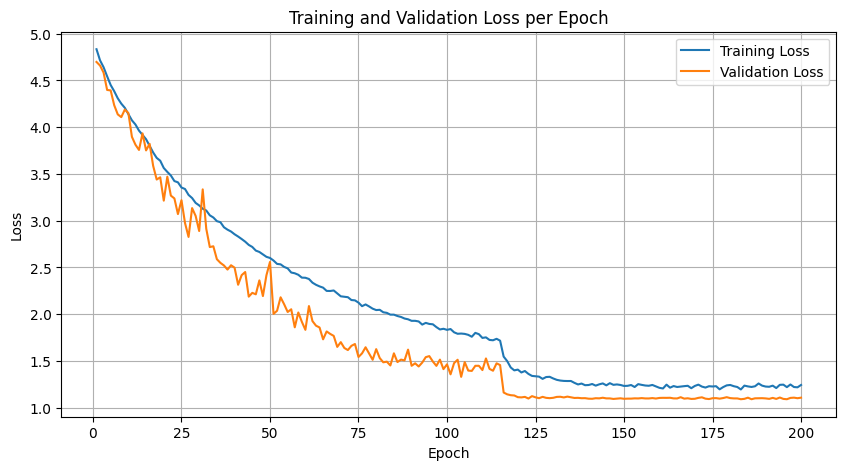

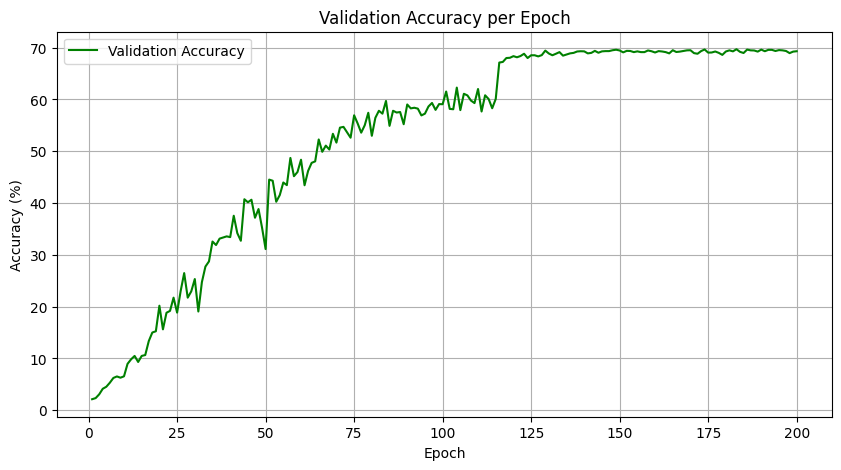

In [8]:
#VER COMO APLICAR CONFUSION MATRIX PARA IDENTIFICAR QUAIS CLASSES SÃO MAIS DIFICEIS E MAIS FACEIS DO MODELO ACERTAR(depois)
# Plot de treino e validadion loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

# Plot de acuracia
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid()
plt.show()


In [10]:
#Fazer previsões para uma imagem
from PIL import Image

# Carregar imagem
image_path = 'borzoi.jpg'
image = Image.open(image_path)
# Pre processar a imagem
image = test_transform(image).unsqueeze(0)  # Add batch dimension
# Mover imagem para a gpu
image = image.to(device)
# Load the best model
model.load_state_dict(torch.load('C:\\Users\\alewa\Desktop\\teste\TrabalhoVisCompFinal\\Modelos\\epoca_183_best_model_acc_69.70_loss_1.0901.pth'))
model.eval()
# Fazer predicao | classificar | inferencia
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted_class = base_dataset.classes[predicted.item()]
print(f"Predicted class: {predicted_class}")

<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
C:\Users\alewa\AppData\Local\Temp\ipykernel_14328\490370932.py:12: SyntaxWarning: invalid escape sequence '\D'
  model.load_state_dict(torch.load('C:\\Users\\alewa\Desktop\\teste\TrabalhoVisCompFinal\\Modelos\\epoca_183_best_model_acc_69.70_loss_1.0901.pth'))


Predicted class: n02090622-borzoi


In [ ]:
# Caminho para o diretório com as imagens ( Varias imagens )
#https://images.cv/

image_dir = 'caminho/para/o/diretorio_com_imagens' 

# Load the best model
model.load_state_dict(torch.load('TrabalhoVisCompFinal/Modelos/epoca_183_best_model_acc_69.70_loss_1.0901.pth'))
model.eval()
model.to(device)

# Lista de extensões válidas de imagem
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

# Percorrer todas as imagens do diretório
for image_name in os.listdir(image_dir):
    if any(image_name.lower().endswith(ext) for ext in valid_extensions):
        image_path = os.path.join(image_dir, image_name)
        
        try:
            # Carregar e pré-processar imagem
            image = Image.open(image_path).convert('RGB')
            image_tensor = test_transform(image).unsqueeze(0).to(device)
            
            # Fazer inferência
            with torch.no_grad():
                output = model(image_tensor)
                _, predicted = torch.max(output, 1)
                predicted_class = base_dataset.classes[predicted.item()]
            
            print(f"{image_name} -> Predicted class: {predicted_class}")
        
        except Exception as e:
            print(f"Erro ao processar {image_name}: {e}")
            